This notebook explores the task of extracting social networks from text: for a given set of people mentioned in a text, can we extract a social network that connects them?  In this social network, people are the nodes, and the edges between them are weighted by the strength of their connection.  How you define what "connection" means here is up to you (within reason).

This notebook requires networkx; install with:

```sh
pip install networkx==2.2
```

In [1]:
import spacy
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
nlp = spacy.load('en', disable=['parser'])

In [7]:
def process(filename):
    with open(filename, encoding="utf-8") as file:
        data=file.read()
        return nlp(data)

Q1. Pick an English-language book you know from [Project Gutenberg](https://www.gutenberg.org) and save it in the `data/` directory.  Read it in here.  What two characters have a strong relationship in this book?

In [8]:
# Default is Austen's Pride and Prejudice
doc=process("../data/pride.txt")

Your main task here will be to create a social network of people mentioned in text.  You will need to implement the following two functions: `get_nodes`, which returns a list of characters in a text along with a weight for them (e.g., their frequency of mention in the text) and `get_edges`, which returns a list of positive weights between those character nodes (if two characters do not have a tie between them, their weight is 0 and you don't have to include them in the edge list).

The interesting question here is how you measure whether a social tie exists between two characters in a text, and how you go about placing a weight on that edge that measures the strength of the tie. Two characters that have a strong tie should have a high weight.  Consider the different ways that we might measure social interaction in text -- the frequency with which two characters are mentioned together, how often they mention each other in dialogue, how "friendly" their interaction seems, etc.

For two previous approaches to this, see Elson et al. (2010) "[Extracting Social Networks from Literary Texts](http://www1.cs.columbia.edu/~delson/pubs/ACL2010-ElsonDamesMcKeown.pdf)" and Stiller et al. 2003, "[The Small World of Shakespeare's Plays](http://www.staff.ncl.ac.uk/daniel.nettle/shakespeare.pdf)".

Q2: Before implementing the two functions, explain how you are defining a social tie, and how you are measuring it in text.

In [186]:
def get_people_mentions(doc, min_count=10):
    """ Extract all of the PERSON mentions in a spacy-processed document.
    Returns a dict mapping each unique person name to a list of spacy entity mentions
    Each spacy entity has the following attributes:
    
    * text
    * start position in document (character)
    * end position in document (character)
    * label (NER category)
    
    https://spacy.io/usage/linguistic-features#named-entities
    """
    people=defaultdict(list)
    for entity in doc.ents:
        if entity.label_ == "PERSON":
            people[entity.text.lstrip().rstrip()].append(entity)
    
    return people

Q3: Implement `get_nodes` below.

In [187]:
def get_nodes(people, min_count=10):
    """ Creates network nodes from a dict of people mentions
    Input: a dict of people mentions returned from get_people_mentions()
    Output: a dict mapping the entity name to a positive numerical value of their importance 
    (the size of the node in a network graph)
    
    e.g., {"Tom": 5, "Huck": 1}
    
    """
    nodes=defaultdict(float)
    total=0.
    for person in people:
        if len(people[person]) >= min_count:
            nodes[person]=len(people[person])
            total+=len(people[person])
    
    for person in nodes:
        nodes[person]/=total
    
    return nodes

Q4. Implement `get_edges` below.

In [188]:
def get_edges(people, doc):
    """ Creates network edges from a dict of people mentions and the full spacy-processed document
    Input: a dict of people mentions returned from get_people_mentions() and document returned from process()
    Output: a dict mapping a person all of the other people they are connected to, along with the weight of
    that connection.
    
    e.g., {"Tom: {"Huck": 2, "Sally": 1}, "Huck": {"Sally": 1}}
    
    Keep in mind that doc gives you access to *all* of the tokens in the book.
    
    """
    
    # Here we'll define the strength of a tie to be one of proximity of mention (two characters who
    # are frequently mentioned together will have a high edge weight).
    def get_counts(person1, person2):

        window=500 # characters
        count=0
        per1_mentions=people[person1]
        per2_mentions=people[person2]

        for p1 in per1_mentions:
            for p2 in per2_mentions:
                if abs(p1.start-p2.start) < window:
                    count+=1

        return count

    edges={}
    total_edges=0.

    for person1 in people:
        if person1 not in edges:
            edges[person1]={}
        for person2 in people:
            if person1 != person2:
                count=get_counts(person1, person2)
                if count >= 5 and (person1 not in edges or person2 not in edges[person1]):
                    edges[person1][person2]=count
                    total_edges+=1

    for person1 in edges:
        for person2 in edges[person1]:
            edges[person1][person2]/=total_edges
    
    return edges

First, let's map *mentions* of character to the unique individuals they refer to.  We'll talk about better ways of doing this when we get to coreference resolution in a couple of weeks, but for now let's make a simplification and just say that every mention with exactly the same form refers to the same individual (so all mentions of "Elizabeth" refer to the character ELIZABETH, all mentions of "Mr. Darcy" refer to MR. DARCY, etc.)

In [189]:
people=get_people_mentions(doc)

In [190]:
nodes=get_nodes(people)

In [191]:
edges=get_edges(people, doc)

In [264]:
def create_graph(nodes, edges):

    """ Plot a set of weighted nodes and weighted edges on a network graph """
    
    # increase this to expand network
    force_directed_expansion=2
    
    # increase these dimensions to make graph bigger
    figure_height=20
    figure_width=20
    
    G = nx.Graph()
    for person in nodes:
        G.add_node(person, nodesize=nodes[person])
    for person1 in edges:
        for person2 in edges[person1]:
            if person1 in nodes and person2 in nodes:
                G.add_weighted_edges_from([(person1, person2, edges[person1][person2]) ])

    options = {
    'edgecolors':"black",
    'linewidths':1,
    'with_labels': True,
    'font_weight': 'regular',
    }
    
    g_edges = G.edges()

    sizes = [G.node[node]['nodesize']*100000 for node in G]
    weights = [G[u][v]['weight']*10 for u,v in g_edges]

    fig, ax = plt.subplots(1, 1, figsize=(figure_height, figure_width));

    nx.draw_networkx(G, pos=nx.spring_layout(G, k=force_directed_expansion, iterations=100), node_size=sizes, width=weights, **options)

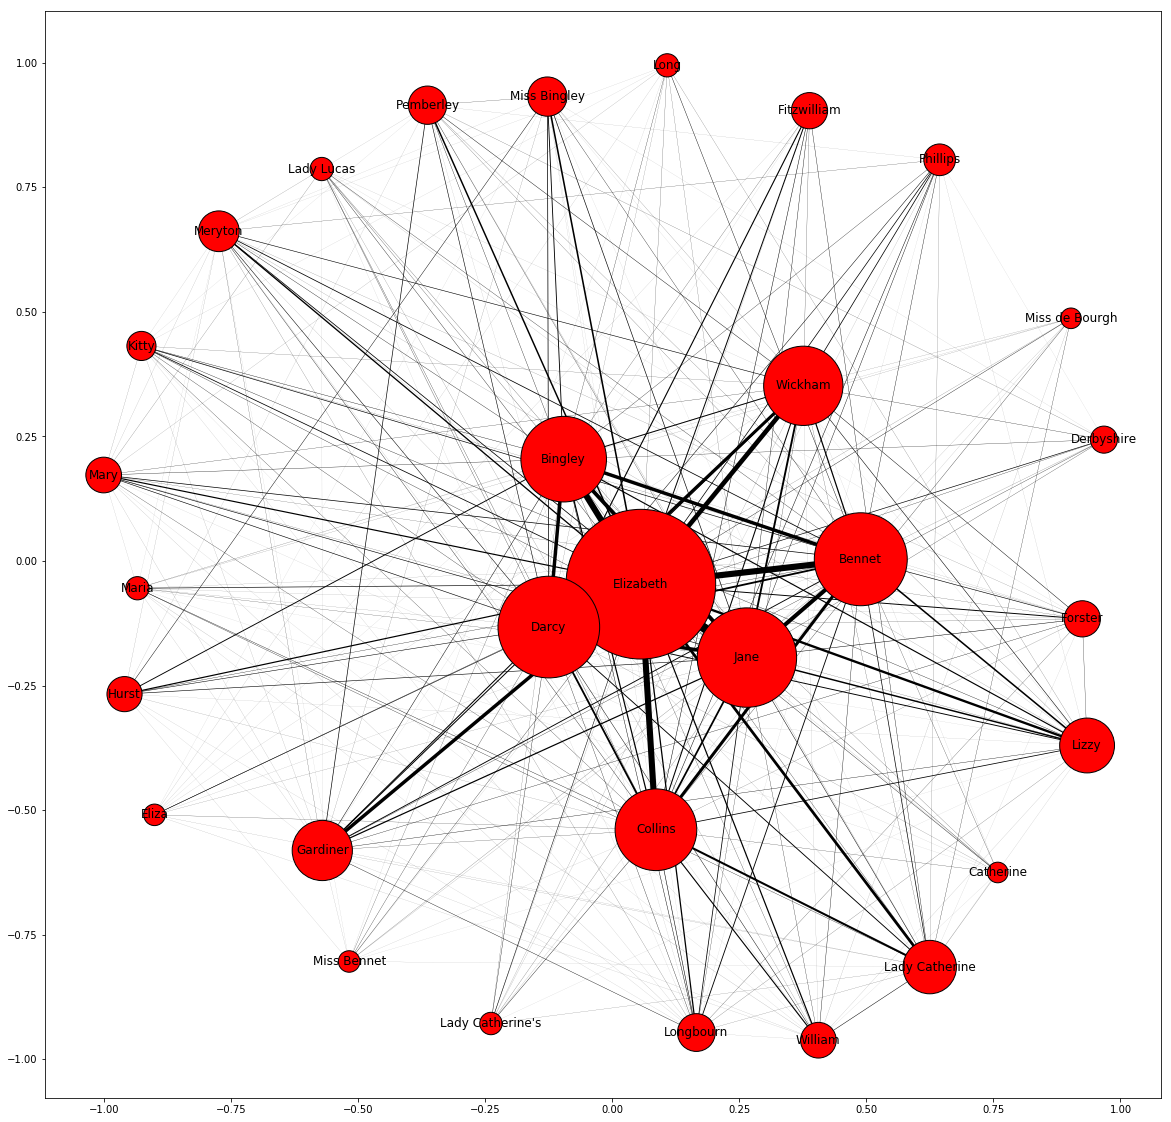

In [255]:
create_graph(nodes, edges)